In [13]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [2]:
#Load & Schema Fix
df = pd.read_csv("../dataset/telco_train.csv")
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
y = df["Churn"].map({"No": 0, "Yes": 1})
X = df.drop(columns=["Churn", "customerID"], errors="ignore")
num_features = X.select_dtypes(include=["int64", "float64"]).columns
cat_features = X.select_dtypes(include=["object"]).columns

In [3]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])
#📌Note:  Decision Tree does NOT need scaling

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features)
    ]
)

In [4]:
dt_clf = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", DecisionTreeClassifier(
        random_state=42,
        class_weight={0: 1, 1: 2},
        max_depth=6,
        min_samples_split=20,
        min_samples_leaf=10
    ))
])


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [6]:
dt_clf.fit(X_train, y_train)
y_pred = dt_clf.predict(X_test)
y_proba = dt_clf.predict_proba(X_test)[:, 1]
# Train / Test accuracy
train_score = dt_clf.score(X_train, y_train)
test_score = dt_clf.score(X_test, y_test)

========== OFFICIAL TEST SET PERFORMANCE ==========
Training Accuracy: 0.7641
Testing Accuracy : 0.7489

Accuracy      : 0.7489
Precision     : 0.5177
Recall        : 0.7826
F1 Score      : 0.6232
ROC-AUC Score : 0.8234
MCC Score     : 0.4678

Confusion Matrix:
[[610 218]
 [ 65 234]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       828
           1       0.52      0.78      0.62       299

    accuracy                           0.75      1127
   macro avg       0.71      0.76      0.72      1127
weighted avg       0.80      0.75      0.76      1127



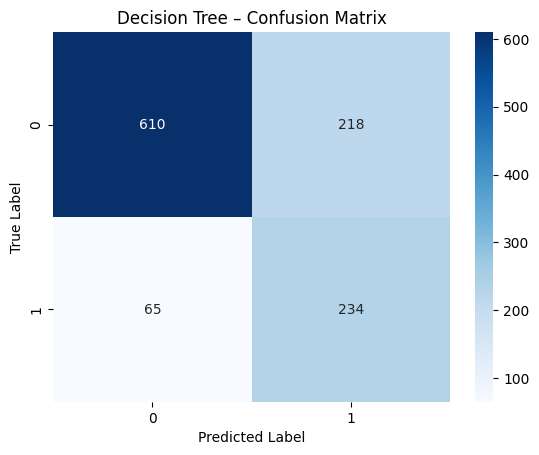

In [7]:
print("========== TRAINING PERFORMANCE ==========")
print(f"Training Accuracy: {train_score:.4f}")
print(f"Testing Accuracy : {test_score:.4f}")
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
mcc = matthews_corrcoef(y_test, y_pred)
print(f"\nAccuracy      : {accuracy:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC-AUC Score : {roc_auc:.4f}")
print(f"MCC Score     : {mcc:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree – Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

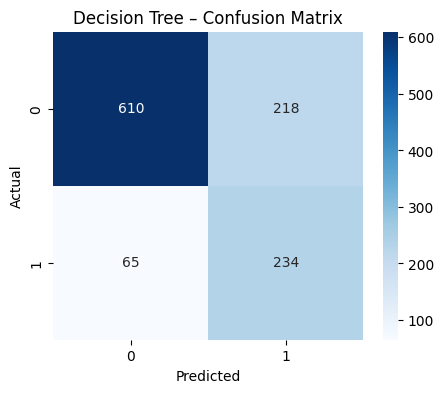

In [8]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree – Confusion Matrix")
plt.show()


In [11]:
joblib.dump(dt_clf, "../models/decision_tree.pkl")

['../models/decision_tree.pkl']

========== TEST PERFORMANCE ==========
Accuracy      : 0.7388
Precision     : 0.5053
Recall        : 0.7647
F1 Score      : 0.6085
ROC-AUC Score : 0.7471
MCC Score     : 0.4451

Confusion Matrix:
[[755 280]
 [ 88 286]]

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.73      0.80      1035
           1       0.51      0.76      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.79      0.74      0.75      1409



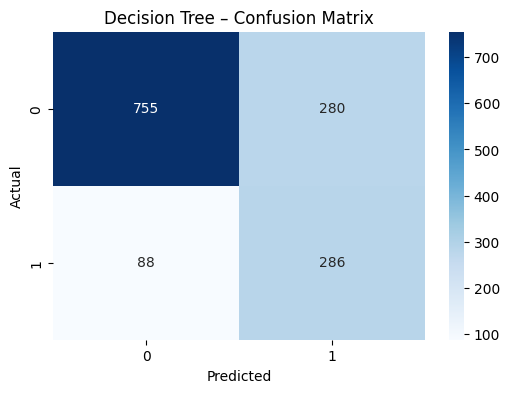

In [12]:
# 1. Load the Decision Tree model
loaded_model = joblib.load("../models/decision_tree.pkl")

# 2. Load and clean test data
test_df = pd.read_csv("../dataset/telco_test.csv")

# Fix TotalCharges issue (same preprocessing as training)
test_df["TotalCharges"] = pd.to_numeric(
    test_df["TotalCharges"], errors="coerce"
).fillna(0)

X_final_test = test_df.drop(columns=["Churn"])
y_final_test = test_df["Churn"].map({"Yes": 1, "No": 0})

# 3. Predict using the LOADED model
y_loaded_pred = loaded_model.predict(X_final_test)

# 4. Evaluation
print("========== TEST PERFORMANCE ==========")

accuracy = accuracy_score(y_final_test, y_loaded_pred)
precision = precision_score(y_final_test, y_loaded_pred)
recall = recall_score(y_final_test, y_loaded_pred)
f1 = f1_score(y_final_test, y_loaded_pred)
roc_auc = roc_auc_score(y_final_test, y_loaded_pred)
mcc = matthews_corrcoef(y_final_test, y_loaded_pred)

print(f"Accuracy      : {accuracy:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"F1 Score      : {f1:.4f}")
print(f"ROC-AUC Score : {roc_auc:.4f}")
print(f"MCC Score     : {mcc:.4f}")

print("\nConfusion Matrix:")
cm = confusion_matrix(y_final_test, y_loaded_pred)
print(cm)

print("\nClassification Report:")
print(classification_report(y_final_test, y_loaded_pred))

# 5. Confusion Matrix Heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Decision Tree – Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
